# Demonstration of Robust Workflow

This notebook demonstrates the use of the RobustWorkflow class from the quends package. This workflow allows a user to process DataStreams that are not stationary if they choose to do so by setting the flag `operate_safe = False`. With this flag set to False, if a DataStream is not stationary, the code will return the mean based on the last 33% of the data, with an uncertainty of 100%. The dictionary of results that is returned also contains metadata to indicate if the DataStream was processed normally, or if there were exceptions (such as non-stationarity), and how those were mitigated.

Note that this workflow currently defaults to heuristic methods for determining stationarity and start of statistical steady state (SSS). These methods mainly look at the behavior of the rolling-window-averaged mean of the signal. These methods are therefore not guaranteeing SSS in the true sense of the definition as they only look at the 0th moment of the statistics. However, the methods work quite well for short and super noisy signals.



## Import Required Libraries and Helper Functions

In [1]:
# Import required libraries
import numpy as np
import quends as qnds
import pprint
import matplotlib.pyplot as plt
import pandas as pd

# Custom class to specify formatting of floats (and tuples of floats) in pprint 
# and limit the number of significant digits in results dictionaries printed to screen
class FloatFormatter(pprint.PrettyPrinter):
    def _format(self, object, stream, indent, allowance, context, level):
        if isinstance(object, tuple):
            stream.write('(')
            for i, item in enumerate(object):
                if isinstance(item, float):
                    stream.write(format(item, '.4g'))
                else:
                    super()._format(item, stream, indent, allowance, context, level)
                if i < len(object) - 1:
                    stream.write(', ')
            stream.write(')')
        elif isinstance(object, float):
            stream.write(format(object, '.4g'))
        else:
            super()._format(object, stream, indent, allowance, context, level)

# use as 'formatter.pprint(object)'
formatter = FloatFormatter(indent=0)


## Demonstration on a variety of signals
For these demonstrations, we set the verbosity to 2 so you can see plots of intermediate steps.

### Synthetic data: linear transient to a plateau with some noise

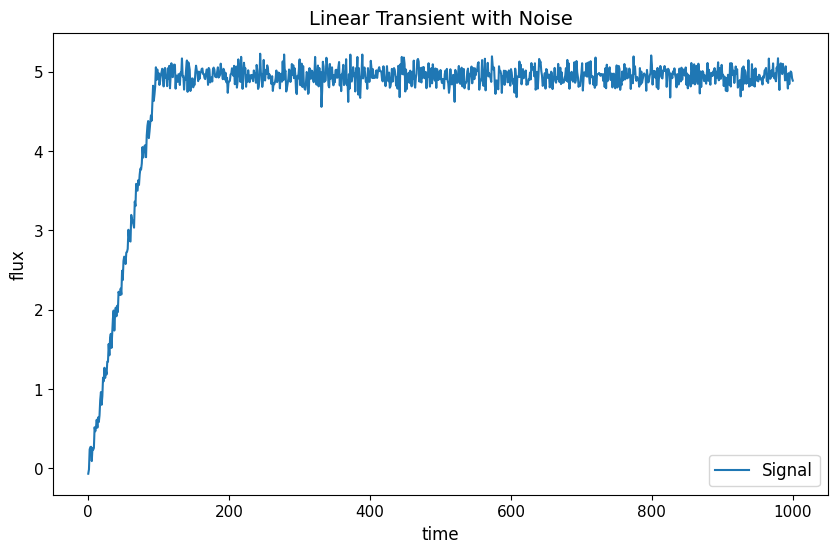

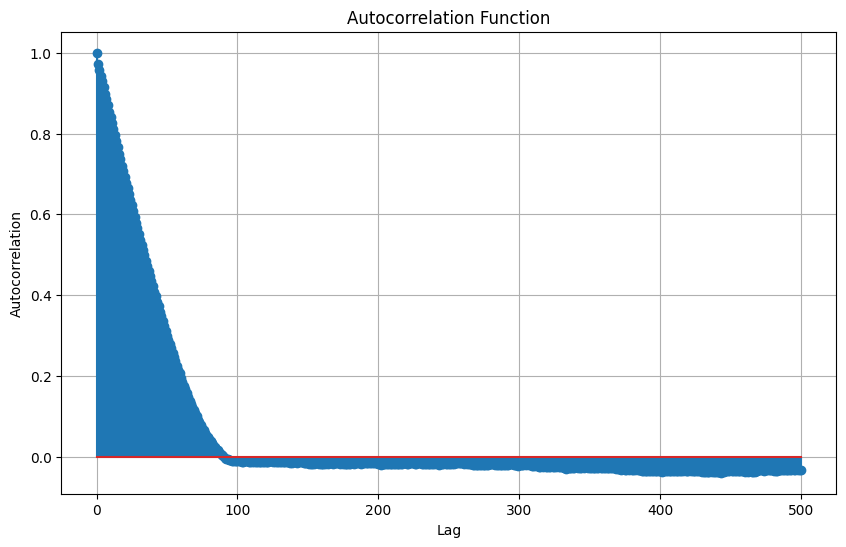

stats decorrelation length 72 gives smoothing window of 288 points.


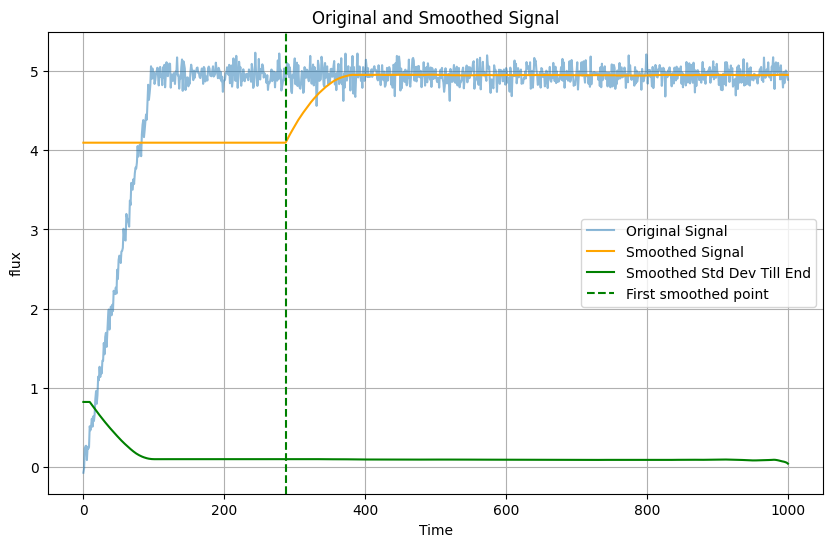

Getting start of SSS based on smoothed signal:
Index where criterion is met: 333
Rolling window: 288
time where criterion is met: 333.0
time at start of SSS (adjusted for rolling window): 102.0


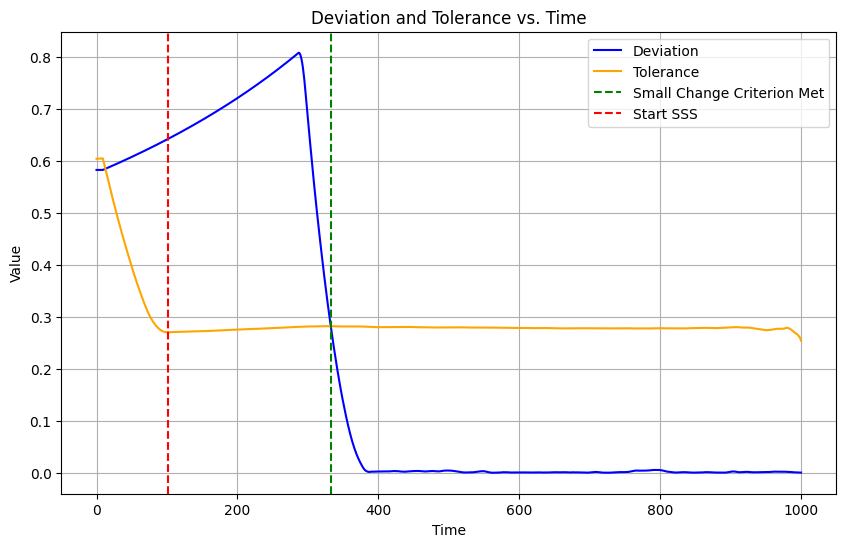

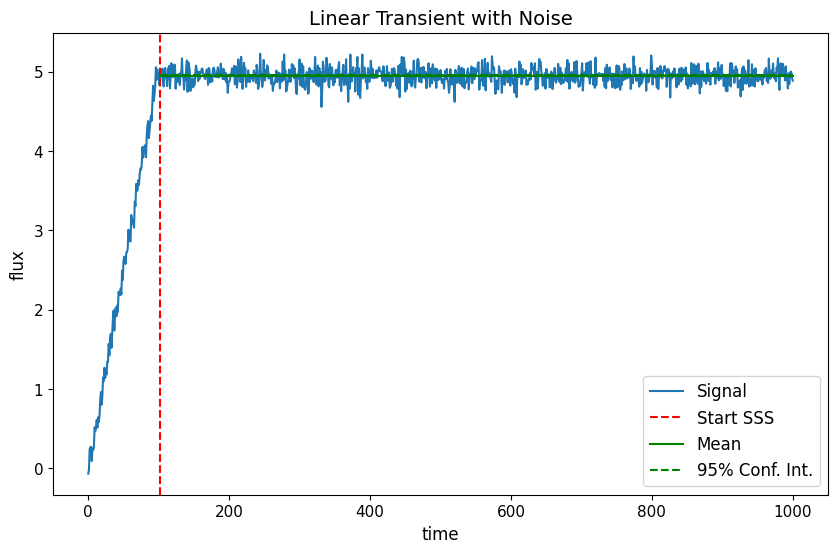

In [ ]:
# Create time trace with linear transient up to flat signal with noise

# set up arrays for time and signal
arr_time = np.linspace(start=0,stop=1000,num=1001)
arr_signal = np.zeros_like(arr_time)

n_pts = arr_signal.shape[0]

for i_arr in range(100):
    arr_signal[i_arr] = 0.05*arr_time[i_arr]
for i_arr in range(100,n_pts):
    arr_signal[i_arr] = arr_signal[99]

# add some noise
arr_signal += np.random.normal(loc=0.0, scale=0.1, size=arr_signal.shape)

my_label = "Linear Transient with Noise"
# build data_stream
df_flat = pd.DataFrame({"time":arr_time,"flux":arr_signal})

ds_flat = qnds.DataStream(df_flat)

# Set up the workflow with high verbosity to see intermediate steps
my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=2)

col = "flux" # variable to look at

# Plot raw signal
my_wrkflw.plot_signal_basic_stats(ds_flat,col,label=my_label)

# get statistics
my_stats = my_wrkflw.process_data_steam(ds_flat,col)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw.plot_signal_basic_stats(ds_flat,col,stats=my_stats,label=my_label)

Analysis:
- The first plot shows the raw signal before doing any processing. 
- The first step in the analysis is to compute the signal autocorrelation (2nd plot), which is used to define a decorrelation length. 
- This decorrelation length is used to define an averaging window (by default 4 x the decorrelation length), which is used to smoothen the signal.
- The third graph shows the orginal signal along with the smoothed signal, as well as the standard deviation of the original signal, computed at each point from the current point till the end of the signal.
- This information is used to determine statistical steady state (SSS) as the tail segment of the orginal signal for which any point of the smoothed signal does not deviate much from the mean of the smoothed segment. The threshold for deviation from the mean is a fraction of the mean of the smoothed signal, and this fraction depends on the std dev of the original signal. In other words, signals that are very noisy allow for larger deviations from the mean while being in SSS. As the points in the smoothed signal depend on all points in the averaging window, the actual start of SSS is set to be a fraction of the averaging window before the point where the SSS criterion is met, as shown in the 4th figure.
- By default, the start of SSS is set to 80% of the averaging window before the criterion is met. The last figure shows how this coincides well with the transition from linear slope to plateau in this synthetic examples. However, as many of the analysis parameters are set very heuristically, this is more due to serendipity than to design.

In [13]:
# Print results
pprint.pprint(my_stats)

{'Q_D/Q_GBD': {'confidence_interval': (35.39973222929892, 40.222473814362274),
               'effective_sample_size': 22,
               'mean': 37.8111030218306,
               'mean_uncertainty': 1.2302912206794254,
               'metadata': {'mitigation': 'None', 'status': 'Regular'},
               'pm_std': (36.58081180115117, 39.04139424251002),
               'sss_start': 43.0,
               'window_size': 65},
 'metadata': [{'operation': 'effective_sample_size',
               'options': {'alpha': 0.05, 'column_names': 'Q_D/Q_GBD'}},
              {'operation': 'compute_statistics',
               'options': {'column_name': 'Q_D/Q_GBD',
                           'ddof': 1,
                           'method': 'non-overlapping',
                           'window_size': None}}]}


The dictionary `my_stats` contains all numerical results of the analysis. The metadata reveals more details about the operations. In this particular case, `mitigation : None` and `status : Regular` means that no special mitigations were needed to process the data.

### "Regular" signals
Demonstration on well-behaved CGYRO and GX runs

The data stream contains the following variables:
0: Unnamed: 0
1: time
2: Q_D/Q_GBD
3: Q_e/Q_GBD


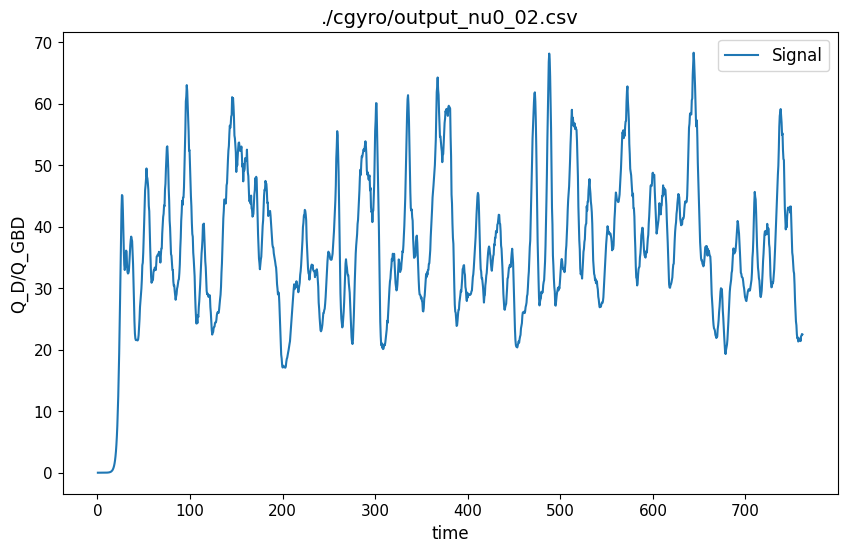

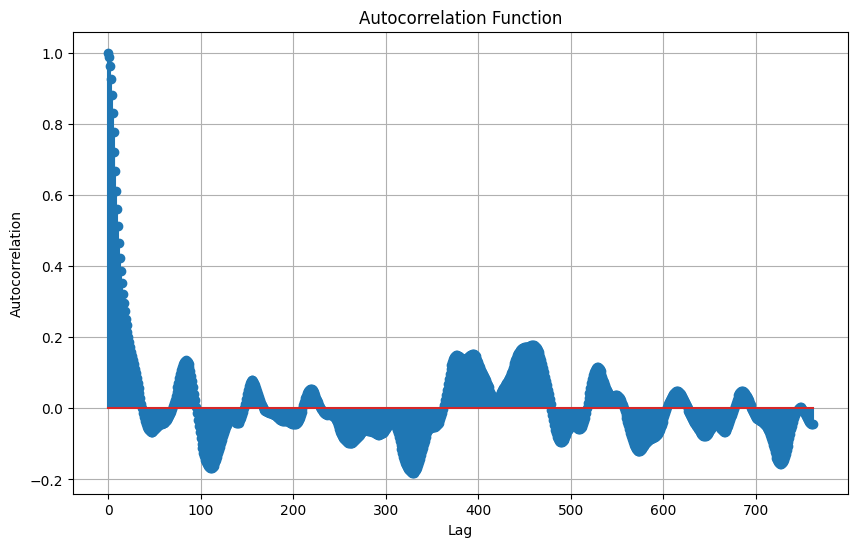

stats decorrelation length 108 gives smoothing window of 432 points.


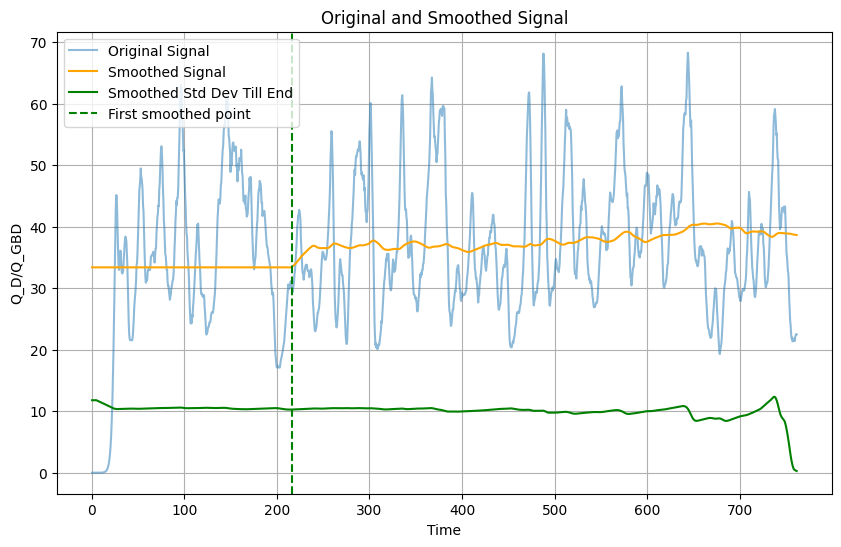

Getting start of SSS based on smoothed signal:
Index where criterion is met: 431
Rolling window: 432
time where criterion is met: 216.0
time at start of SSS (adjusted for rolling window): 43.0


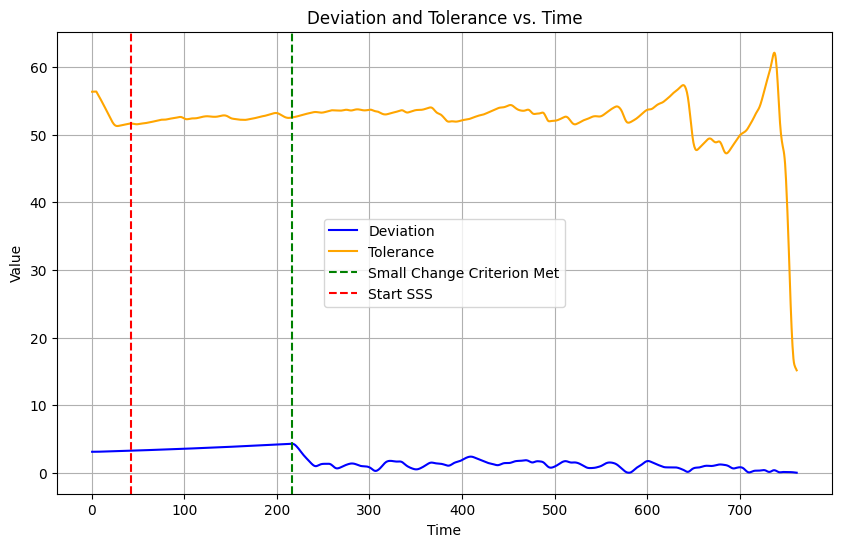

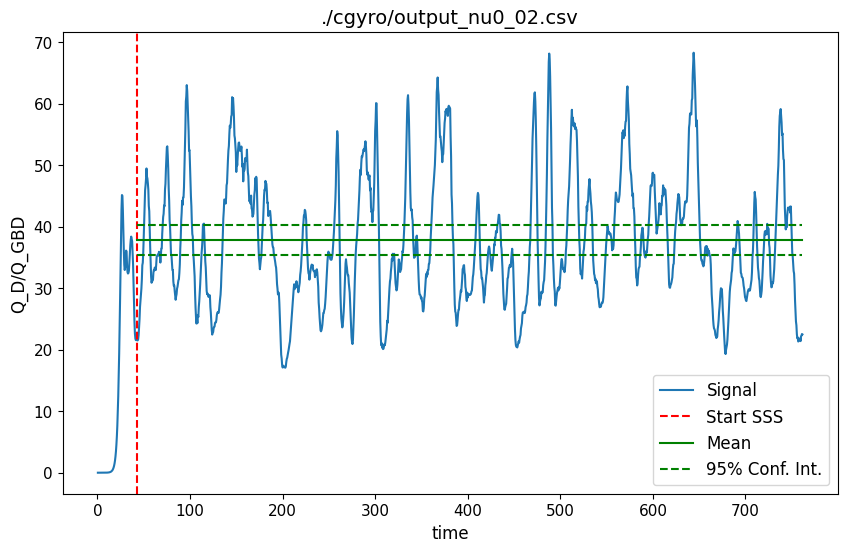

In [15]:
# Specify the file path
data_paths = ["./cgyro/output_nu0_02.csv"]

# Load one data file to see what variables they contain.
# Assume all files have the same variables in them
data_stream = qnds.from_csv(data_paths[0])
data_vars = data_stream.variables()
print("The data stream contains the following variables:")
for column, name in enumerate(data_vars):
    print(f"{column}: {name}")

col = data_vars[2] # work with first variable (stored after index and time)

# Plot raw signal
my_wrkflw.plot_signal_basic_stats(data_stream,col,label=data_paths[0])

# Set up workflow object
my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=2)

# Get statistics
my_stats = my_wrkflw.process_data_steam(data_stream,col)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw.plot_signal_basic_stats(data_stream,col,stats=my_stats,label=data_paths[0])


In [16]:
# Print results
pprint.pprint(my_stats)

{'Q_D/Q_GBD': {'confidence_interval': (35.39973222929892, 40.222473814362274),
               'effective_sample_size': 22,
               'mean': 37.8111030218306,
               'mean_uncertainty': 1.2302912206794254,
               'metadata': {'mitigation': 'None', 'status': 'Regular'},
               'pm_std': (36.58081180115117, 39.04139424251002),
               'sss_start': 43.0,
               'window_size': 65},
 'metadata': [{'operation': 'effective_sample_size',
               'options': {'alpha': 0.05, 'column_names': 'Q_D/Q_GBD'}},
              {'operation': 'compute_statistics',
               'options': {'column_name': 'Q_D/Q_GBD',
                           'ddof': 1,
                           'method': 'non-overlapping',
                           'window_size': None}}]}


For this example, the analysis is pretty straighforward, and most of the signal is in SSS as the mean is quite steady and the signal has a high std dev, which gives the mean of the SSS segment quite a bit of wiggle room in the criterion.

The data stream contains the following variables:
0: time
1: Phi2_t
2: Phi2_kxt
3: Phi2_kyt
4: Phi2_kxkyt
5: Phi2_zt
6: Apar2_t
7: Apar2_kxt
8: Apar2_kyt
9: Apar2_kxkyt
10: Apar2_zt
11: Phi2_zonal_t
12: Phi2_zonal_kxt
13: Phi2_zonal_zt
14: Wg_st
15: Wg_kxst
16: Wg_kyst
17: Wg_kxkyst
18: Wg_zst
19: Wg_lmst
20: Wphi_st
21: Wphi_kxst
22: Wphi_kyst
23: Wphi_kxkyst
24: Wphi_zst
25: Wapar_st
26: Wapar_kxst
27: Wapar_kyst
28: Wapar_kxkyst
29: Wapar_zst
30: HeatFlux_st
31: HeatFlux_kxst
32: HeatFlux_kyst
33: HeatFlux_kxkyst
34: HeatFlux_zst
35: HeatFluxES_st
36: HeatFluxES_kxst
37: HeatFluxES_kyst
38: HeatFluxES_kxkyst
39: HeatFluxES_zst
40: HeatFluxApar_st
41: HeatFluxApar_kxst
42: HeatFluxApar_kyst
43: HeatFluxApar_kxkyst
44: HeatFluxApar_zst
45: HeatFluxBpar_st
46: HeatFluxBpar_kxst
47: HeatFluxBpar_kyst
48: HeatFluxBpar_kxkyst
49: HeatFluxBpar_zst
50: ParticleFlux_st
51: ParticleFlux_kxst
52: ParticleFlux_kyst
53: ParticleFlux_kxkyst
54: ParticleFlux_zst
55: TurbulentHeating_st
56: Turbule

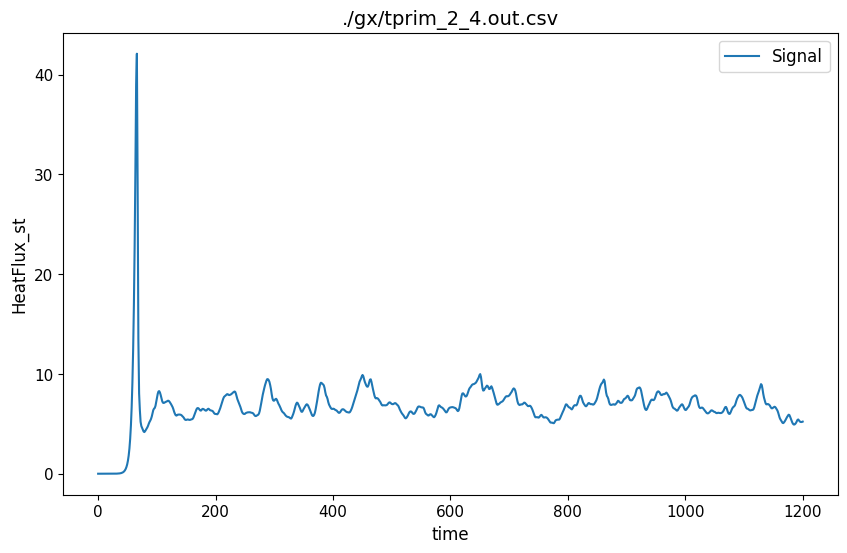

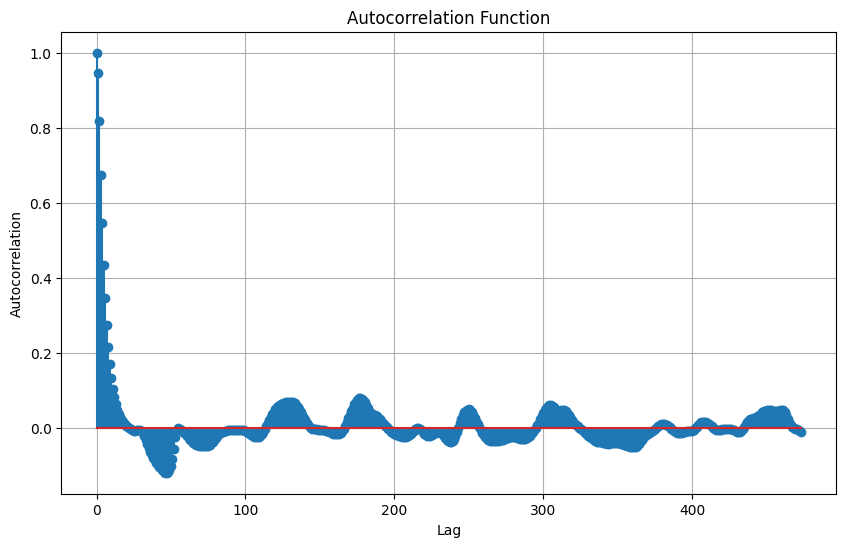

stats decorrelation length 17 gives smoothing window of 68 points.


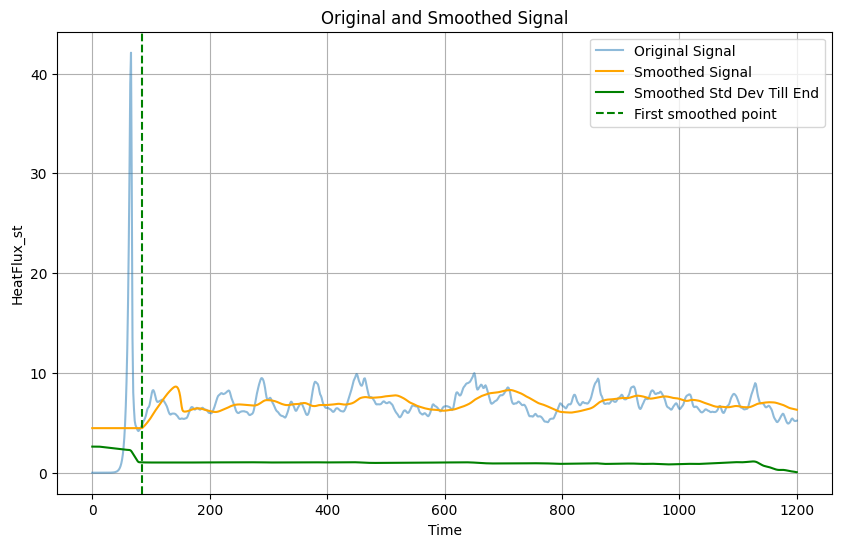

Getting start of SSS based on smoothed signal:
Index where criterion is met: 575
Rolling window: 68
time where criterion is met: 729.4152185935495
time at start of SSS (adjusted for rolling window): 659.6462806224445


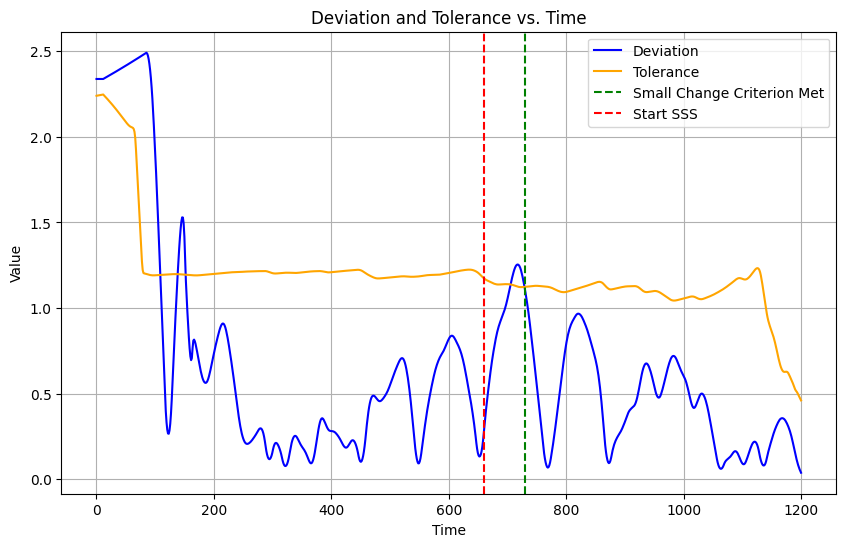

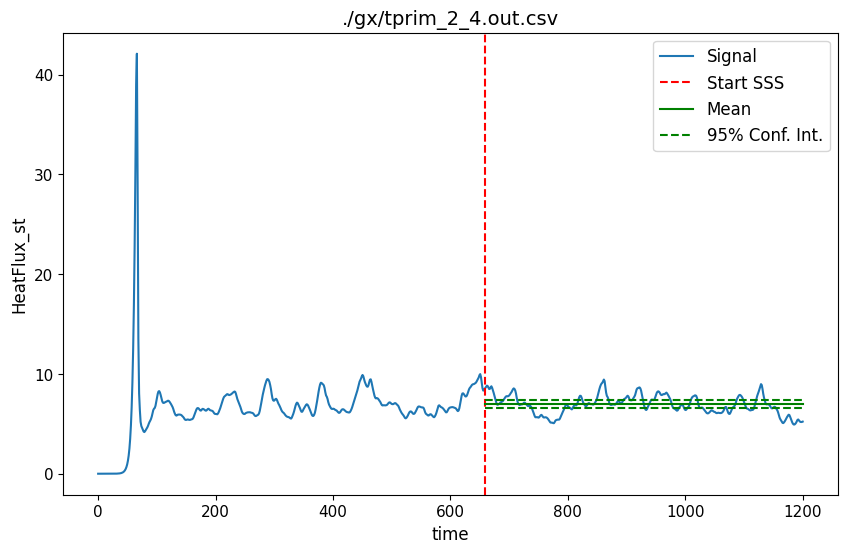

In [ ]:
# GX data trace
# Specify the file path
data_paths = ["./gx/tprim_2_4.out.csv"]

# Load one data file to see what variables they contain.
# Assume all files have the same variables in them
data_stream = qnds.from_csv(data_paths[0])
data_vars = data_stream.variables()
print("The data stream contains the following variables:")
for column, name in enumerate(data_vars):
    print(f"{column}: {name}")

col = "HeatFlux_st"

# Plot raw signal
my_wrkflw.plot_signal_basic_stats(data_stream,col,label=data_paths[0])

# Set up workflow object
my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=2)

# Get statistics
my_stats = my_wrkflw.process_data_steam(data_stream,col)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw.plot_signal_basic_stats(data_stream,col,stats=my_stats,label=data_paths[0])


In [25]:
# Print results
pprint.pprint(my_stats)

{'HeatFlux_st': {'confidence_interval': (6.536765296142947, 7.371993357445566),
                 'effective_sample_size': 11,
                 'mean': 6.954379326794257,
                 'mean_uncertainty': 0.2130683829853618,
                 'metadata': {'mitigation': 'None', 'status': 'Regular'},
                 'pm_std': (6.741310943808895, 7.167447709779618),
                 'sss_start': 659.6462806224445,
                 'window_size': 38},
 'metadata': [{'operation': 'effective_sample_size',
               'options': {'alpha': 0.05, 'column_names': 'HeatFlux_st'}},
              {'operation': 'compute_statistics',
               'options': {'column_name': 'HeatFlux_st',
                           'ddof': 1,
                           'method': 'non-overlapping',
                           'window_size': None}}]}


For this example, the decorrelation length is rather short, resulting in more variability in the smoothed signal. About half the signal is in SSS. This looks like a fair assessment, although one could make the case that SSS should start maybe around 160. Per the graph that shows the deviation and the tolerance, this would be about where the algorithm would place the start of SSS if it were not for the one bump in the deviation around t = 700. If one is faced with a batch of signals where this persistently happens, one could increase the `decor_multiplier` above the default of 4 to get more smoothing, or increase `std_dev_frac`

### Signal that is not stationary
This data signal was built by adding a linear trend to a stationary signal.

The data stream contains the following variables:
0: Unnamed: 0
1: time
2: Q_D/Q_GBD
3: Q_e/Q_GBD


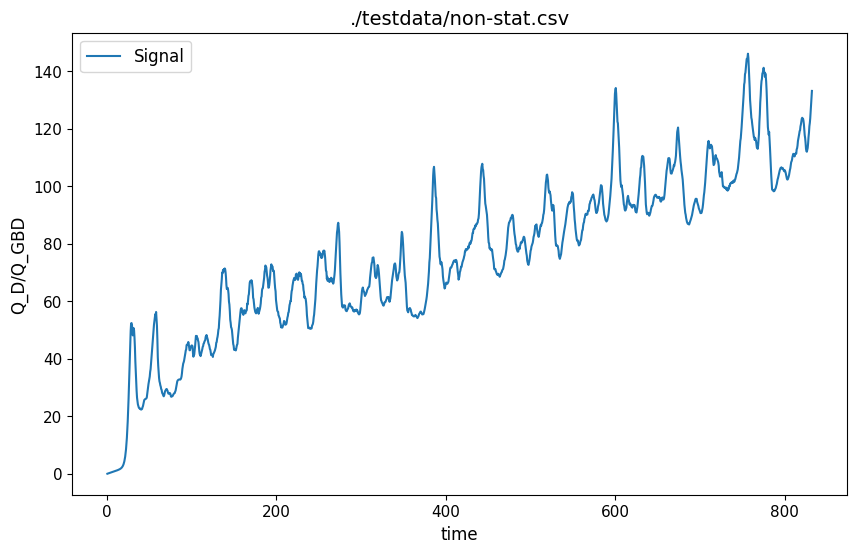

Data stream is not stationary, even after dropping first 416 points.
Data stream is not stationary, even after dropping first 728 points.
Data stream is not stationary, even after dropping first 962 points.
Data stream was not stationary, but is stationary after dropping first 1137 points.


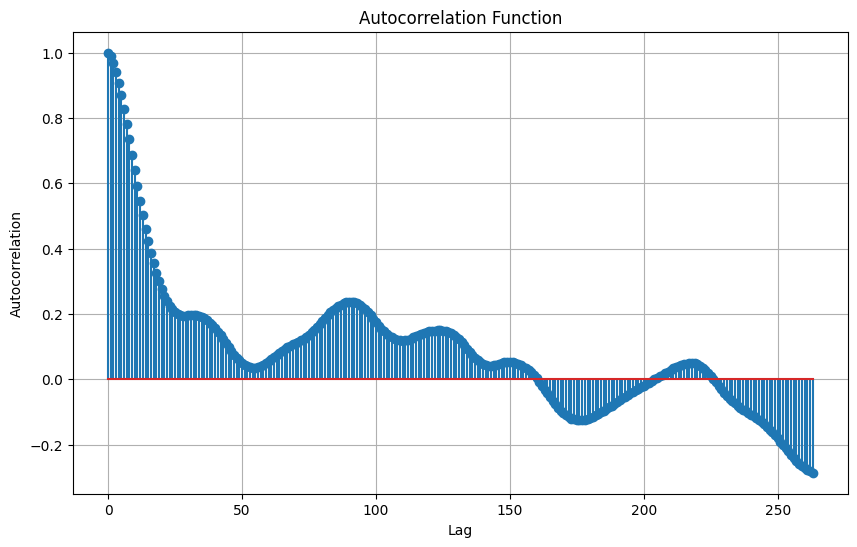

stats decorrelation length 72 gives smoothing window of 263 points.


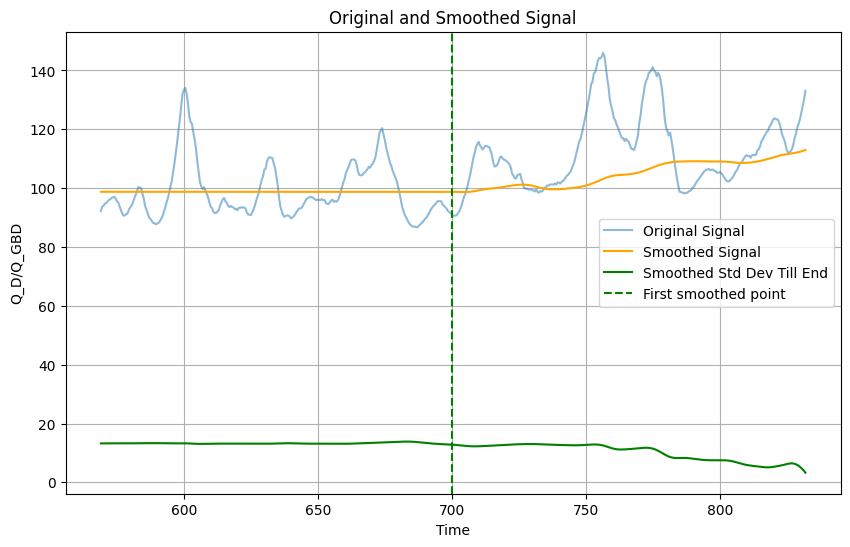

Getting start of SSS based on smoothed signal:
Index where criterion is met: 262
Rolling window: 263
time where criterion is met: 700.0
time at start of SSS (adjusted for rolling window): 594.5


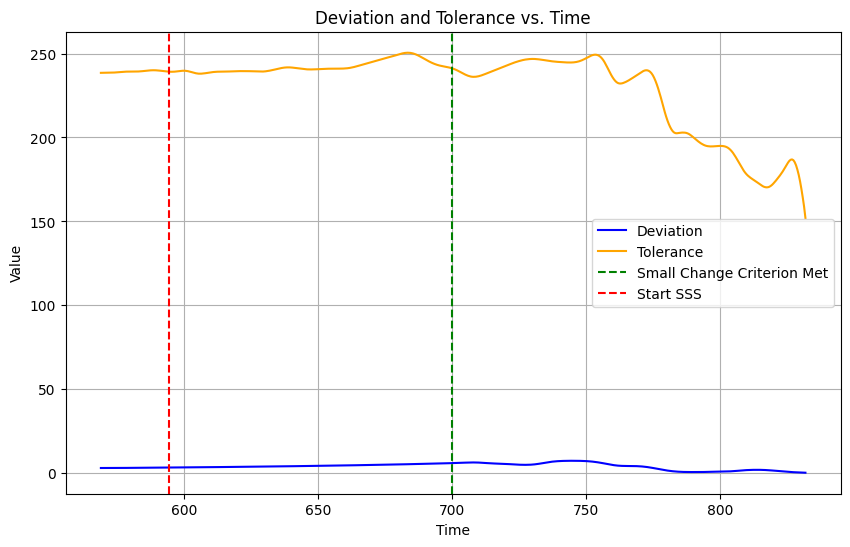

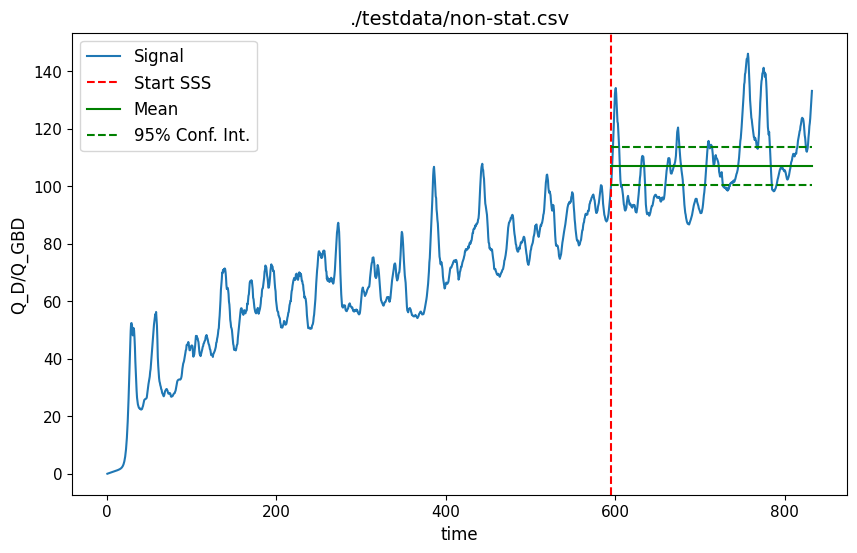

In [17]:
# Specify the file path
data_paths = ["./testdata/non-stat.csv"]

# Load one data file to see what variables they contain.
# Assume all files have the same variables in them
data_stream = qnds.from_csv(data_paths[0])
data_vars = data_stream.variables()
print("The data stream contains the following variables:")
for column, name in enumerate(data_vars):
    print(f"{column}: {name}")

col = data_vars[2] # work with first variable (stored after index and time)

# Plot raw signal
my_wrkflw.plot_signal_basic_stats(data_stream,col,label=data_paths[0])

# Set up workflow object
my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=2)

# Get statistics
my_stats = my_wrkflw.process_data_steam(data_stream,col)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw.plot_signal_basic_stats(data_stream,col,stats=my_stats,label=data_paths[0])


In [18]:
# Print results
pprint.pprint(my_stats)

{'Q_D/Q_GBD': {'confidence_interval': (100.48093043166715, 113.48055370725326),
               'effective_sample_size': 11,
               'mean': 106.9807420694602,
               'mean_uncertainty': 3.3162304274454373,
               'metadata': {'mitigation': 'None', 'status': 'Regular'},
               'pm_std': (103.66451164201477, 110.29697249690564),
               'sss_start': 594.5,
               'window_size': 43},
 'metadata': [{'operation': 'effective_sample_size',
               'options': {'alpha': 0.05, 'column_names': 'Q_D/Q_GBD'}},
              {'operation': 'compute_statistics',
               'options': {'column_name': 'Q_D/Q_GBD',
                           'ddof': 1,
                           'method': 'non-overlapping',
                           'window_size': None}}]}


When the full data stream is analyzed, the algorithm determines it to be non-stationary. Rather than abort, this current workflow repeatedly drops a fraction of the data (25% by default) to see if the data stream becomes stationary after dropping some initial transients. Eventually, the segment is short enough and the noise large enough that the signal is deemed to be stationary and a segment is found to be in SSS. 

On the one hand, one could argue that this is a failure of the robust workflow. On the other hand, the mean flux returned to the user does give some information on the magnitude that the flux in this trace is trending to. And the large uncertainty in the returned flux can be an indicator that something is off. If the end user does not want a signal like this to be retained as stationary, then the minimum # of points to retain in the data stream can be adjusted. As shown below.

The data stream contains the following variables:
0: Unnamed: 0
1: time
2: Q_D/Q_GBD
3: Q_e/Q_GBD


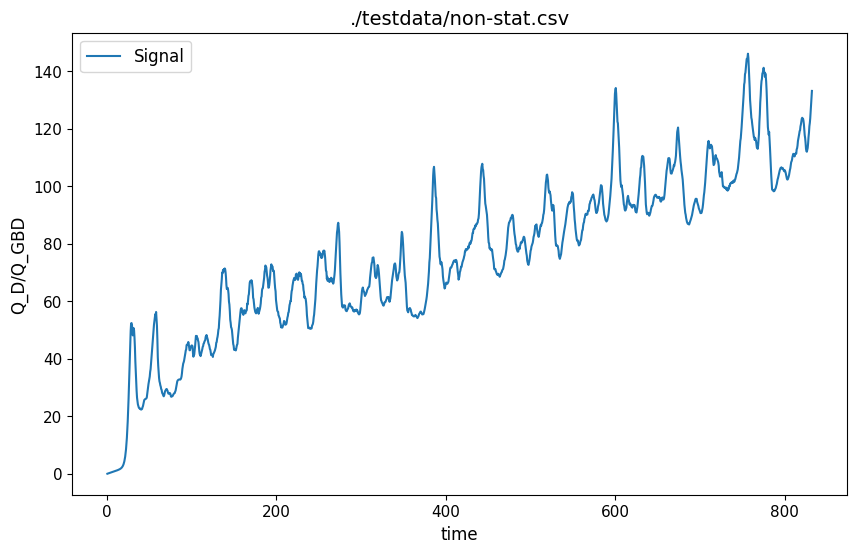

Data stream is not stationary, even after dropping first 416 points.
Data stream is not stationary, even after dropping first 728 points.
Data stream is not stationary.


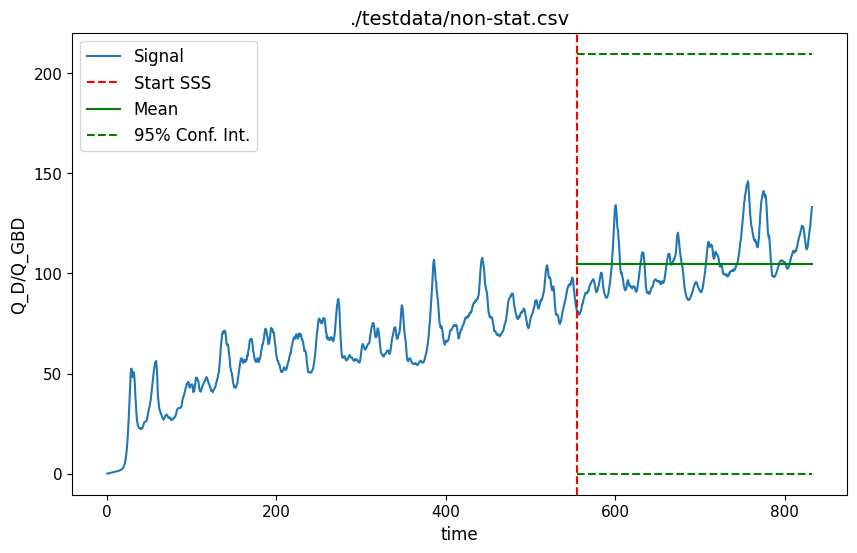

In [19]:
# Specify the file path
data_paths = ["./testdata/non-stat.csv"]

# Load one data file to see what variables they contain.
# Assume all files have the same variables in them
data_stream = qnds.from_csv(data_paths[0])
data_vars = data_stream.variables()
print("The data stream contains the following variables:")
for column, name in enumerate(data_vars):
    print(f"{column}: {name}")

col = data_vars[2] # work with first variable (stored after index and time)

# Plot raw signal
my_wrkflw.plot_signal_basic_stats(data_stream,col,label=data_paths[0])

# Set up workflow object
my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=2, n_pts_min=1000)

# Get statistics
my_stats = my_wrkflw.process_data_steam(data_stream,col)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw.plot_signal_basic_stats(data_stream,col,stats=my_stats,label=data_paths[0])


In [20]:
# Print results
pprint.pprint(my_stats)

{'Q_D/Q_GBD': {'confidence_interval': (0.0, 209.58287485484882),
               'mean': 104.79143742742441,
               'mean_uncertainty': 104.79143742742441,
               'metadata': {'mitigation': 'AdHoc',
                            'status': 'NoStatSteadyState'},
               'sss_start': 555.0}}


In this analysis, the algorithm starts to drop initial fragments of the data stream to see if the latter part of the data stream is stationary. However, once the signal contains fewer than 1000 points, the he algorithm stops and declares the data stream non-stationary.

Since the safe processing option was turned off, the algorithm returns the mean of the last 1/3 of the data stream with an arbitrary confidence interval from 0 to twice the mean of this last 1/3 of the data stream. The metadata in the results dictionary indicates that an adhoc result was returned due to the non-stationarity of the data stream.

If the workflow used safe processing, no results would have been returned.

### Demo a situation where the data is stationary but there is no statistical steady state found due to bad hyperparameters


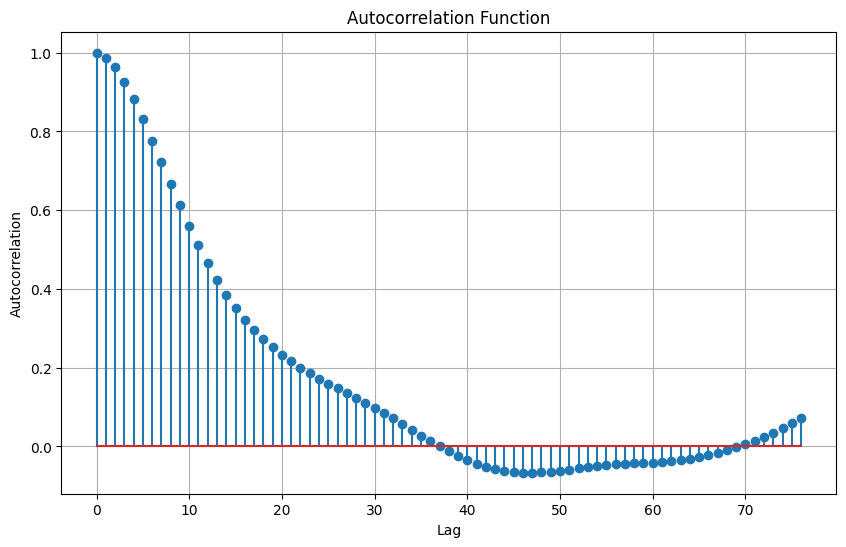

stats decorrelation length 30 gives smoothing window of 30 points.


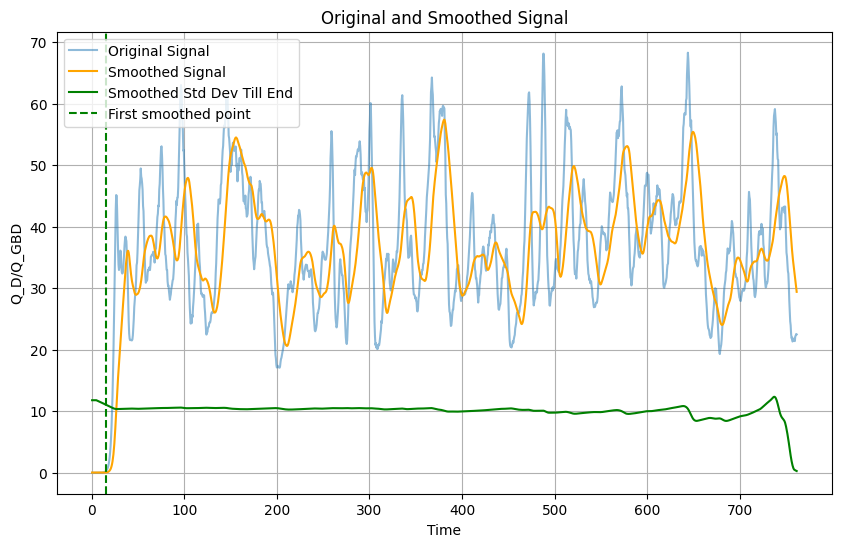

Getting start of SSS based on smoothed signal:
No SSS found based on behavior of mean of smoothed signal.


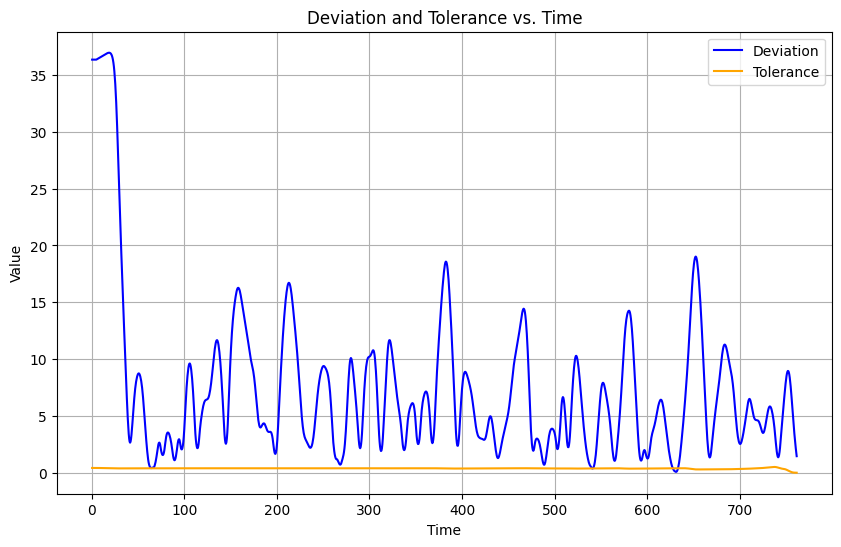

No statistical steady state found after trimming.


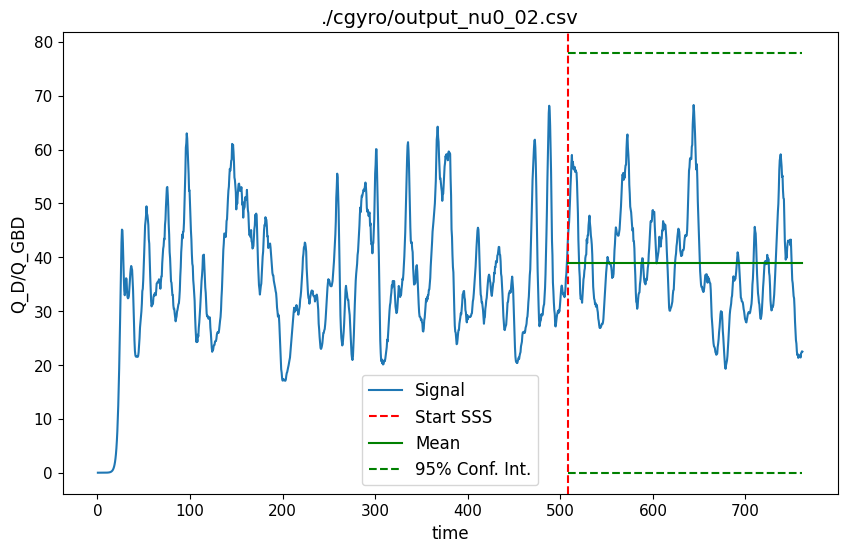

In [36]:
data_path = "./cgyro/output_nu0_02.csv"
ds0 = qnds.from_csv(data_path)

# Set up workflow object and use very badly chosen hyperparameters
my_wrkflw0 = qnds.RobustWorkflow(operate_safe=False, verbosity=2, max_lag_frac=0.05,decor_multiplier=1.0,std_dev_frac=0.001,fudge_fac=0.0)

col = 'Q_D/Q_GBD'

# Get statistics
my_stats0 = my_wrkflw0.process_data_steam(ds0,col)


# Plot trace with mean and start of steady state
if not my_stats0[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw0.plot_signal_basic_stats(ds0,col,my_stats0,label=data_path)


In [31]:
# Print results
print(f"Results for {data_path}:") 
formatter.pprint(my_stats0)

Results for ./cgyro/output_nu0_02.csv:
{'Q_D/Q_GBD': {'confidence_interval': (0, 77.97),
             'mean': 38.99,
             'mean_uncertainty': 38.99,
             'metadata': {'mitigation': 'AdHoc', 'status': 'NoStatSteadyState'},
             'sss_start': 508}}


In this case, the workflow arguments `max_lag_frac=0.05,decor_multiplier=1.0,std_dev_frac=0.001,fudge_fac=0.0` together cause a short averaging window and a low tolerance for deviations, so that the algorithm can not find a segment in SSS. Accordingly, and adhoc result is returned (based on last 1/3 of data stream), with a large uncertainty.

## Demonstration of batch processing on a set of files 

The data stream contains the following variables:
0: Unnamed: 0
1: time
2: Q_D/Q_GBD
3: Q_e/Q_GBD

Processing ./cgyro/output_nu0_02.csv:


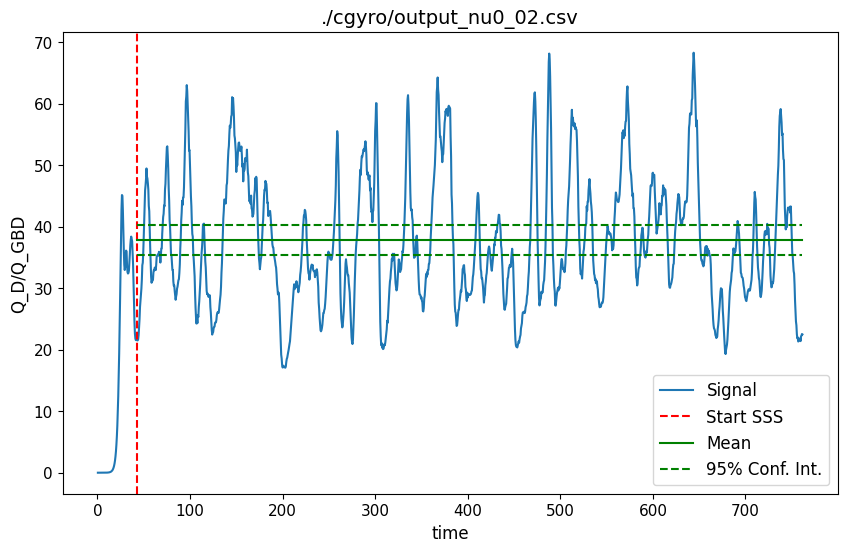


Processing ./cgyro/output_nu0_05.csv:


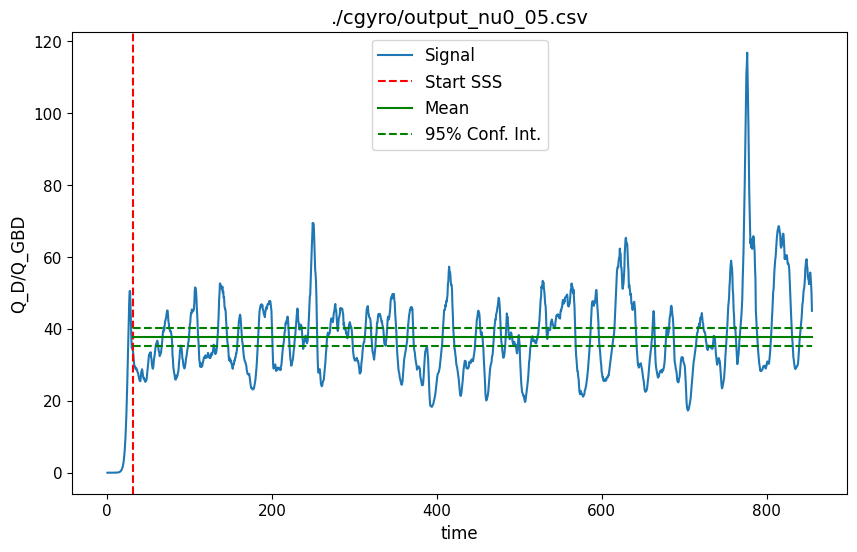


Processing ./cgyro/output_nu0_10.csv:


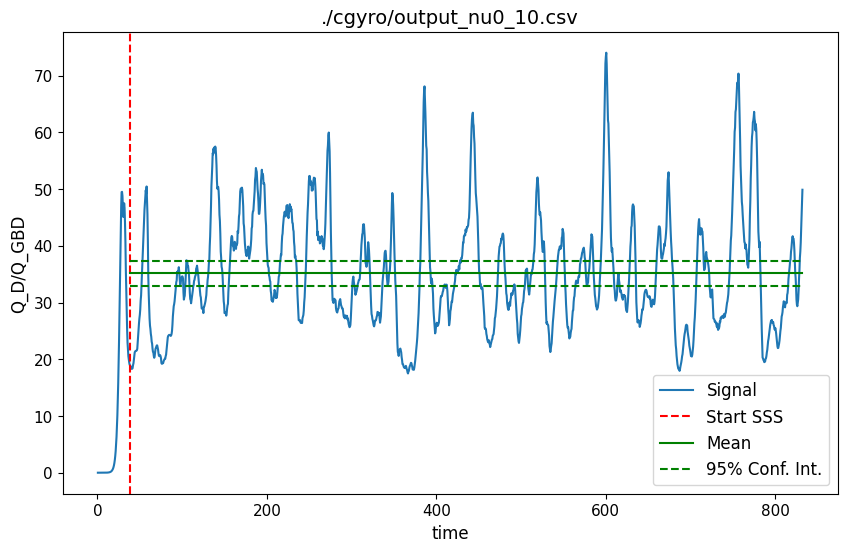


Processing ./cgyro/output_nu0_50.csv:


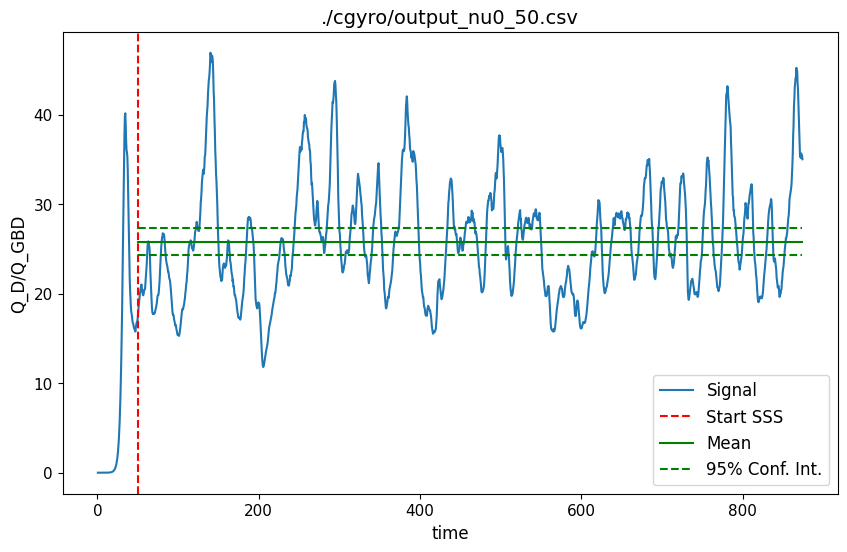


Processing ./cgyro/output_nu1_0.csv:


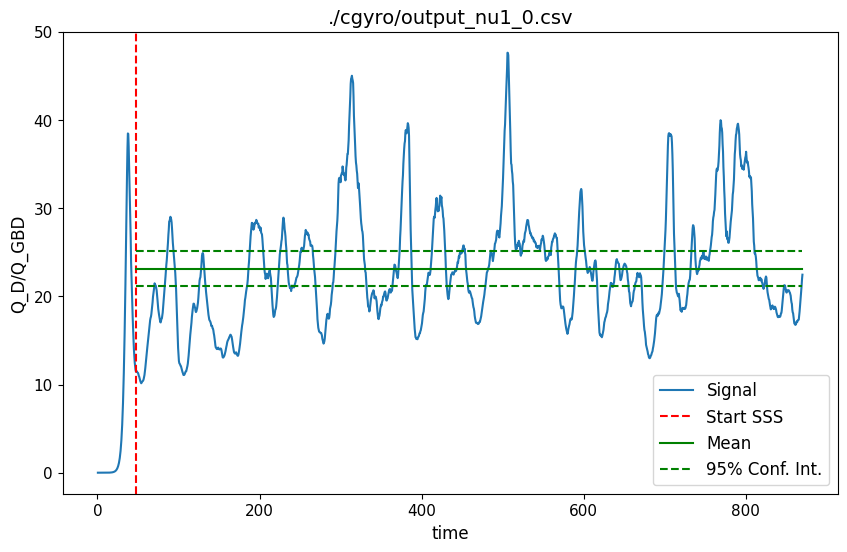

In [38]:
# Specify the file paths, for a set of runs to process in batch
data_paths = ["./cgyro/output_nu0_02.csv", "./cgyro/output_nu0_05.csv", "./cgyro/output_nu0_10.csv", "./cgyro/output_nu0_50.csv", "./cgyro/output_nu1_0.csv"]

# Load one data file to see what variables they contain.
# Assume all files have the same variables in them
data_stream = qnds.from_csv(data_paths[0])
data_vars = data_stream.variables()
print("The data stream contains the following variables:")
for column, name in enumerate(data_vars):
    print(f"{column}: {name}")

col = data_vars[2] # work with first variable (stored after index and time)

# Set up workflow object with low verbosity for batch processing
my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=0)

# arrays to track statistics
flux_means = np.empty((len(data_paths),),dtype=float)
flux_unc   = np.empty((len(data_paths),),dtype=float)

# Process files
for i_data, data_path in enumerate(data_paths):
    print(f"\nProcessing {data_path}:")
    # Load the data into a data_stream object
    data_stream = qnds.from_csv(data_path)

    # Get statistics
    my_stats = my_wrkflw.process_data_steam(data_stream,col)

    # Plot trace with mean and start of steady state
    if not my_stats[col]["metadata"]["mitigation"] == "Drop":
        my_wrkflw.plot_signal_basic_stats(data_stream,col,stats=my_stats,label=data_path)

    # gather mean and uncertainties
    flux_means[i_data] = my_stats[col]["mean"]
    flux_unc[i_data]   = my_stats[col]["mean_uncertainty"]
    

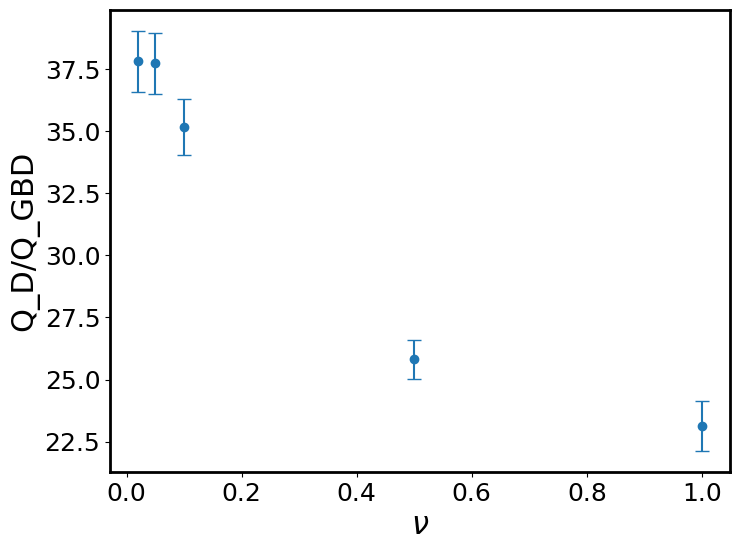

In [40]:
# plot flux_means with uncertainties from flux_unc as error bars. QoI vs. nu

# set text sizes
leg_fs = 18
label_fs = 22
tick_fs = 18

import re
nu_values = []
for path in data_paths:
    match = re.search(r'nu([0-9_]+)\.csv', path)
    if match:
        nu_str = match.group(1).replace('_', '.')
        nu_values.append(float(nu_str))

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(nu_values, flux_means, yerr=flux_unc, fmt='o', capsize=5, label='Flux Mean with Uncertainty')
ax.set_xlabel(r'$\nu$', size=label_fs)
ax.set_ylabel(col, size=label_fs)

# Set frame widths and other sizes
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(axis='both', labelsize=tick_fs)

# plt.savefig("flux_nu.pdf", bbox_inches="tight")
# plt.savefig("flux_nu.png", bbox_inches="tight", dpi=600)